
# Project: Exploration d'un ensemble de donnée sur les matches de Foot

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

 Ce rapport est une analyse d'un ensemble de donnée sur les différents matches de Football de différents payes de l’Europe, les données sont en format SQLITE qu'après exploration des différentes tables et relations j'ai importé deux tables avec les données nécessaire à notre analyse, la première table Matches contient les différents matches toutes League confondu où j'ai remplacé les **foreigne key** avec leur nom, la deuxième table team_attribut contient les suivie des performance sur chaque équipe sur une période temps.<br><br>
 C'est deux table nous aiderons à répondre aux questions sur la relation entre performance et résultat de matche et aussi sur les trait de jeu sur de chaque pays.<br><br>
 la premiére table à était importer avec la requete SQL suivante : 
 <br>**_$\color{blue}{\text{SELECT}}$ c.name as Pays, l.name as league,m.date as date, t.team_long_name as home, t2.team_long_name as away, m.home_team_goal as home_goal, m.away_team_goal<br>
$\color{blue}{\text{From}}$ Country c,League l, Match m, Team t, Team t2<br>
$\color{blue}{\text{Where}}$ c.id = m.country_id AND l.id=m.league_id AND t.team_api_id = m.home_team_api_id and t2.team_api_id=m.away_team_api_id_**<br></br>
 Le code SQL de la deuxième table est le suivant : 
 <br>**_$\color{blue}{\text{SELECT}}$ l.name,t.team_long_name, ta.date, ta.buildUpPlaySpeed, ta.buildUpPlayDribbling, ta.buildUpPlayPassing, ta.buildUpPlayPositioningClass, ta.chanceCreationShooting, ta.defencePressure, ta.defenceAggression
<br>$\color{blue}{\text{From}}$ Team t, Team_Attributes ta, League l,(SELECT DISTINCT m1.league_id, m1.home_team_api_id from Match m1) m
<br>$\color{blue}{\text{Where}}$ t.team_api_id = ta.team_api_id AND t.team_api_id=m.home_team_api_id AND m.league_id = l.id
<br>$\color{blue}{\text{Order by}}$ ta.team_api_id DESC_**
<br><br>
 Nous allons commencer par importer les packages et les deux datasets dans la section qui suit: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df_m= pd.read_csv('matches.csv')
df_at = pd.read_csv('team_attributes.csv')


<a id='wrangling'></a>
## Data Wrangling

### Proprieté génèrale

Dans cette partie nous allons explorer la Dataframe pour se familiariser avec les données et détecter les erreurs afin de les corriger dans la partie data Cleaning.

In [2]:
df_m.head()

,Pays,league,date,home,away,home_goal,away_team_goal
0,Belgium,Belgium Jupiler League,2008-08-17 00:00:00,KRC Genk,Beerschot AC,1,1
1,Belgium,Belgium Jupiler League,2008-08-16 00:00:00,SV Zulte-Waregem,Sporting Lokeren,0,0
2,Belgium,Belgium Jupiler League,2008-08-16 00:00:00,KSV Cercle Brugge,RSC Anderlecht,0,3
3,Belgium,Belgium Jupiler League,2008-08-17 00:00:00,KAA Gent,RAEC Mons,5,0
4,Belgium,Belgium Jupiler League,2008-08-16 00:00:00,FCV Dender EH,Standard de Liège,1,3


Comme nous le remarquons le tableau enregistre les matches qui ont eu lieu entre 2008 et 2016, dans notre analyse nous allons voir s'il y a des corrélations entre les attributs et le pourcentage de Win, pour cette raison il faut diviser pour chaque matche les deux équipes dans deux lignes différentes pour avoir le schéma suivant : équipe, résultat, buts marqué, buts encaissé. afin de simplifier l'analyse.

In [3]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Pays            25979 non-null  object
 1   league          25979 non-null  object
 2   date            25979 non-null  object
 3   home            25979 non-null  object
 4   away            25979 non-null  object
 5   home_goal       25979 non-null  int64 
 6   away_team_goal  25979 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.4+ MB


In [4]:
df_m.describe()

,home_goal,away_team_goal
count,25979.000000,25979.000000
mean,1.544594,1.160938
std,1.297158,1.142110
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,10.000000,9.000000


La fonction **info()** de pandas nous montre qu'il y a pas de donnée manquantes dans le set de donnée et les types sont correctes sauf la date qui doit être changer en datetime.

In [5]:
df_at.head()

,name,team_long_name,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,buildUpPlayPositioningClass,chanceCreationShooting,defencePressure,defenceAggression
0,Belgium Jupiler League,Royal Excel Mouscron,2015-09-10 00:00:00,50,50.0,50,Organised,50,45,45
1,Italy Serie A,Carpi,2014-09-19 00:00:00,32,46.0,31,Organised,54,46,44
2,Italy Serie A,Carpi,2015-09-10 00:00:00,80,45.0,65,Organised,50,25,55
3,Portugal Liga ZON Sagres,FC Arouca,2014-09-19 00:00:00,69,66.0,39,Organised,46,35,37
4,Portugal Liga ZON Sagres,FC Arouca,2015-09-10 00:00:00,65,66.0,39,Organised,46,37,39


Le tableau contient les attribut de chaque équipe enregistrer par année, pour la prochaine étape nous allons détecter s'il y a des valeurs manquantes, des valeurs fausses ou des types de données non conforme.

In [6]:
df_at.describe()

,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationShooting,defencePressure,defenceAggression
count,1458.000000,489.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,52.462277,48.607362,48.490398,53.969136,46.017147,49.251029
std,11.545869,9.678290,10.896101,10.327566,10.227225,9.738028
min,20.000000,24.000000,20.000000,22.000000,23.000000,24.000000
25%,45.000000,42.000000,40.000000,48.000000,39.000000,44.000000
50%,52.000000,49.000000,50.000000,53.000000,45.000000,48.000000
75%,62.000000,55.000000,55.000000,61.000000,51.000000,55.000000
max,80.000000,77.000000,80.000000,80.000000,72.000000,72.000000


In [7]:
df_at.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         1458 non-null   object 
 1   team_long_name               1458 non-null   object 
 2   date                         1458 non-null   object 
 3   buildUpPlaySpeed             1458 non-null   int64  
 4   buildUpPlayDribbling         489 non-null    float64
 5   buildUpPlayPassing           1458 non-null   int64  
 6   buildUpPlayPositioningClass  1458 non-null   object 
 7   chanceCreationShooting       1458 non-null   int64  
 8   defencePressure              1458 non-null   int64  
 9   defenceAggression            1458 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 114.0+ KB


D'après les résultats des fonction de pandas nous remarquons premièrement que la colonne buildUpPlayDribling contient beaucoup de valeurs manquantes, due à son importance dans notre analyse nous allons la conserver et faire l'analyse sur un échantillon réduit mais qui peut nous aider à avoir une idée sur l'impact de cet attributs sur le winrate de l'équipe. <br>
Concernant les types on doit changer toutes les colonnes contenant des chiffres en même type et de changer le type de date en **dateTime**.


### Data Cleaning 

Nous allons commencer par commencer par la première table afin de restructurer les colonnes et faciliter notre analyse.
1. la première étape est de changer les types de données
2. la deuxième étape est de créer un data set sur les matches de chaque équipe avec les résultats des matches, les buts marqués et encaissés afin de simplifié le calcul des Winrates.


In [8]:
df_m1 = df_m[['Pays','league','date','home','home_goal','away_team_goal']]
#renomer les colonnes
df_m1=df_m1.rename(columns={'home':'team','home_goal':'scored','away_team_goal':'conceded'})
#changer le type en datetime
df_m1['date']=pd.to_datetime(df_m1['date'])
#creer une colonne résultat du matche
selection = [(df_m1['scored']>df_m1['conceded']),(df_m1['scored']<df_m1['conceded']),(df_m1['scored']==df_m1['conceded'])]
rslt=['win','lose','egality']
df_m1['result']= np.select(selection,rslt)
# le resultat
df_m1.head()

,Pays,league,date,team,scored,conceded,result
0,Belgium,Belgium Jupiler League,2008-08-17,KRC Genk,1,1,egality
1,Belgium,Belgium Jupiler League,2008-08-16,SV Zulte-Waregem,0,0,egality
2,Belgium,Belgium Jupiler League,2008-08-16,KSV Cercle Brugge,0,3,lose
3,Belgium,Belgium Jupiler League,2008-08-17,KAA Gent,5,0,win
4,Belgium,Belgium Jupiler League,2008-08-16,FCV Dender EH,1,3,lose


In [9]:
df_m2 = df_m[['Pays','league','date','away','away_team_goal','home_goal']]
#renomer les colonnes
df_m2=df_m2.rename(columns={'away':'team','away_team_goal':'scored','home_goal':'conceded'})
#changer le type en datetime
df_m2['date']=pd.to_datetime(df_m2['date'])
#creer une colonne résultat du matche
selection = [(df_m2['scored']>df_m2['conceded']),(df_m2['scored']<df_m2['conceded']),(df_m2['scored']==df_m2['conceded'])]
rslt=['win','lose','egality']
df_m2['result']= np.select(selection,rslt)
# le resultat
df_m2.head()

,Pays,league,date,team,scored,conceded,result
0,Belgium,Belgium Jupiler League,2008-08-17,Beerschot AC,1,1,egality
1,Belgium,Belgium Jupiler League,2008-08-16,Sporting Lokeren,0,0,egality
2,Belgium,Belgium Jupiler League,2008-08-16,RSC Anderlecht,3,0,win
3,Belgium,Belgium Jupiler League,2008-08-17,RAEC Mons,0,5,lose
4,Belgium,Belgium Jupiler League,2008-08-16,Standard de Liège,3,1,win


Nous allons combiner les deux datasets en une seule table

In [10]:
df_m = pd.concat([df_m1,df_m2])
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51958 entries, 0 to 25978
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Pays      51958 non-null  object        
 1   league    51958 non-null  object        
 2   date      51958 non-null  datetime64[ns]
 3   team      51958 non-null  object        
 4   scored    51958 non-null  int64         
 5   conceded  51958 non-null  int64         
 6   result    51958 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 3.2+ MB


In [11]:
df_at.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         1458 non-null   object 
 1   team_long_name               1458 non-null   object 
 2   date                         1458 non-null   object 
 3   buildUpPlaySpeed             1458 non-null   int64  
 4   buildUpPlayDribbling         489 non-null    float64
 5   buildUpPlayPassing           1458 non-null   int64  
 6   buildUpPlayPositioningClass  1458 non-null   object 
 7   chanceCreationShooting       1458 non-null   int64  
 8   defencePressure              1458 non-null   int64  
 9   defenceAggression            1458 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 114.0+ KB


Dans cette partie nous allons nettoyer la deuxième table sur les attributs de chaque équipe.
1. changement du type de la colonne date en datetime
2. changement du type de _buildUpPlayDribbling_ en int comme les autres colonnes mais in a des valeur null dans la colonne il est nécessaire de sélectionné que les variable non null, il est plus facile de le faire durant l'analyse


In [12]:
df_at['date']=pd.to_datetime(df_at['date'])

Maintenant que les données dont néttoyer nous pouvant commencer l'exploration des données et répondre au questions

<a id='eda'></a>
## Analyse des données exloratoire

### Question 1 (Que sont les attributs fort de chaque league de foot)

Nous allons grouper les données par leaque et regarder la moyenne de chaue attribus


In [13]:
df_at.groupby(['name']).mean()['buildUpPlaySpeed']

name
Belgium Jupiler League      53.391753
England Premier League      56.210784
France Ligue 1              53.214660
Germany 1. Bundesliga       56.419162
Italy Serie A               54.634286
Netherlands Eredivisie      45.962963
Poland Ekstraklasa          50.083333
Portugal Liga ZON Sagres    48.281250
Scotland Premier League     56.533333
Spain LIGA BBVA             47.368984
Switzerland Super League    51.483871
Name: buildUpPlaySpeed, dtype: float64

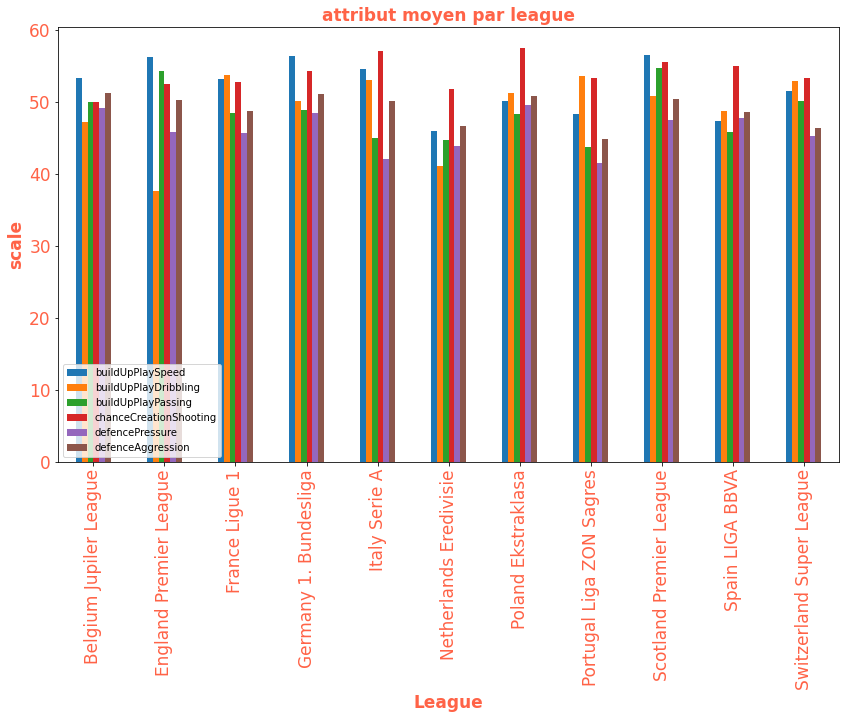

In [14]:
df_at.groupby(['name']).mean().plot(kind='bar',figsize=(14,8))
plt.title('attribut moyen par league',color='tomato' ,fontsize = 17,fontweight ='bold')
plt.xlabel('League', fontweight ='bold', fontsize = 17,color='tomato')
plt.ylabel('scale', fontweight ='bold', fontsize = 17,color='tomato')
plt.xticks(color='tomato' ,fontsize = 17);
plt.yticks(color='tomato' ,fontsize = 17);
plt.legend(loc='lower left');

Comme remarquer au niveau du BARPLOT chaque League se caractérise par des attributs fort et moins fort:
- Belgique : son point fort est l'augmentation de la vitesse de jeu et deuxième l'agressivité en défense
- England : se caractérise par l'augmentation de la vitesse de jeu et création du jeu par les passe
- France : a trois caractéristique proche l'augmentation de la vitesse de jeu, dribling et la création de chance de tir
- Allemagne : ses points forts sont vitesse et création de chance de tir 
- Italy : ses points forts sont vitesse et création de chance de tir 
- Pays-Bas : son point fort est la création de chance de tir 
- Poland : son point fort est la création de chance de tir 
- Potugal : ses points forts sont le dribbling et la création de chance de tir 
- Écosse : ses points forts sont vitesse, les passes et le tirs au but
- Espagne : son points fort est la création des chances de tir 
- Suisse : ses points forts sont le tir et le dribbling


### Question 2  (pour chaque league quelle sont les équipes qui ont le plus de winrate sur la période d'analyse)

Nous allons dans cette partie grouper la dataframe par league et par equipe afin de pouvoir calculer le le winrate e chaque équipe.

In [15]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51958 entries, 0 to 25978
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Pays      51958 non-null  object        
 1   league    51958 non-null  object        
 2   date      51958 non-null  datetime64[ns]
 3   team      51958 non-null  object        
 4   scored    51958 non-null  int64         
 5   conceded  51958 non-null  int64         
 6   result    51958 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 3.2+ MB


In [16]:
df_m3=df_m.query('result=="win"').groupby(['league','team'])['result'].count()/df_m.groupby(['league','team'])['result'].count()

In [17]:
df_m3=df_m3.to_frame()
df_m3.rename(columns={'result':'winrate'}, inplace=True)
df_m3

winrate
league                   team                             
Belgium Jupiler League   Beerschot AC             0.263158
                         Club Brugge KV           0.580189
                         FCV Dender EH            0.264706
                         KAA Gent                 0.500000
                         KAS Eupen                0.166667
...                                                    ...
Switzerland Super League FC Zürich                0.419580
                         Grasshopper Club Zürich  0.402098
                         Lugano                   0.250000
                         Neuchâtel Xamax          0.285714
                         Servette FC              0.285714

[296 rows x 1 columns]

In [18]:
def get_max3(x):
    return x.sort_values(by='winrate',ascending=False).head(3)
maxwinrate=df_m3.groupby('league',as_index=False).apply(get_max3)
maxwinrate

winrate
   league                   team                         
0  Belgium Jupiler League   RSC Anderlecht       0.641509
                            Club Brugge KV       0.580189
                            KAA Gent             0.500000
1  England Premier League   Manchester United    0.631579
                            Chelsea              0.578947
                            Manchester City      0.575658
2  France Ligue 1           Paris Saint-Germain  0.575658
                            Olympique Lyonnais   0.503289
                            LOSC Lille           0.483553
3  Germany 1. Bundesliga    FC Bayern Munich     0.709559
                            Borussia Dortmund    0.577206
                            Bayer 04 Leverkusen  0.503676
4  Italy Serie A            Juventus             0.627907
                            Roma                 0.534653
                            Napoli               0.508306
5  Netherlands Eredivisie   Ajax                 0.665441
                            PSV                  0.654412
                            FC Twente            0.529412
6  Poland Ekstraklasa       Legia Warszawa       0.570833
                            Lech Poznań          0.516667
                            Wisła Kraków         0.450000
7  Portugal Liga ZON Sagres SL Benfica           0.745968
                            FC Porto             0.737903
                            Sporting CP          0.580645
8  Scotland Premier League  Celtic               0.717105
                            Rangers              0.710526
                            Motherwell           0.401316
9  Spain LIGA BBVA          FC Barcelona         0.769737
                            Real Madrid CF       0.750000
                            Atlético Madrid      0.549342
10 Switzerland Super League FC Basel             0.629371
                            BSC Young Boys       0.496503
                            FC Zürich            0.419580

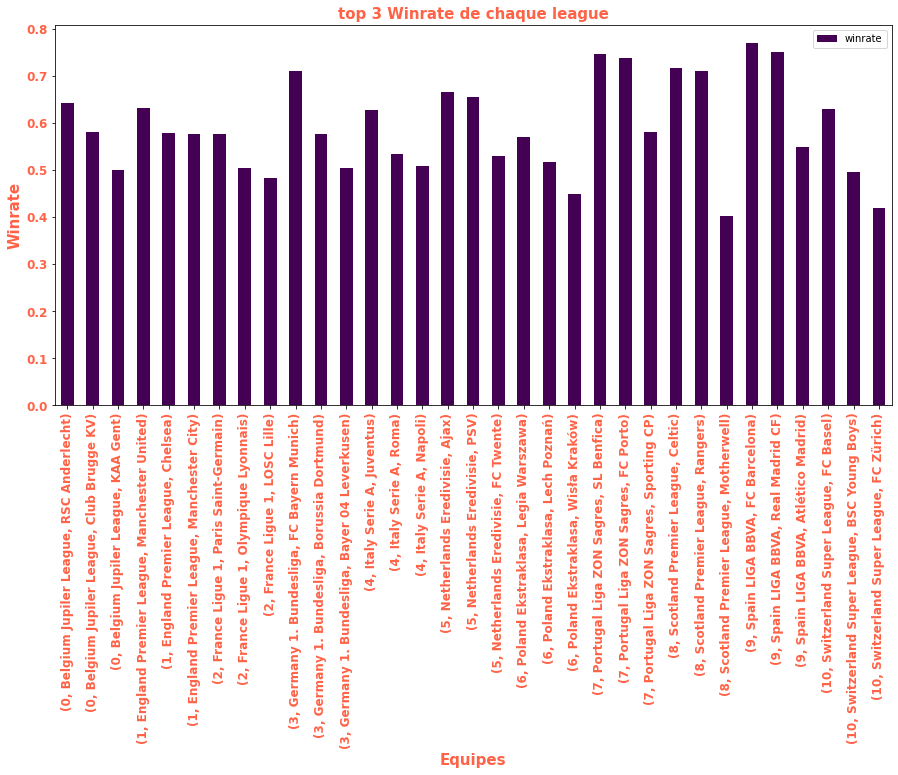

In [19]:
# creat a visualization for the finding
maxwinrate.plot(kind='bar',figsize =(15, 7),cmap="viridis")
plt.ylabel('Winrate',color='tomato', fontweight ='bold', fontsize = 15)
plt.xlabel('Equipes',color='tomato', fontweight ='bold', fontsize = 15)
plt.title('top 3 Winrate de chaque league', color='tomato', fontweight ='bold', fontsize = 15);
plt.xticks(color='tomato', fontweight ='bold', fontsize = 12);
plt.yticks(color='tomato', fontweight ='bold', fontsize = 12);

On constate que se les ligues Portugal, espagne, scotland et l'allemagne il y a une grande domination d'une ou deux équipes avec un winrate de plus de 70% ce qui explique leurs dominance aussi sur la ligue des champions.

### Question 3  (quelle relation y a t'il entre le score de dribling, passes et tir sur le winrate d'une équipe )

Dans cette partie nous allons regrouper winrate et attribue dans une seule table afin de creer un nuage de point qui nous montre s'il y a un correlation entre le **winrate** et les autre variables indépendentes

In [20]:
#mering the two datasets
df_cor = pd.merge(df_m3,df_at.groupby('team_long_name',as_index=False).mean(),left_on='team',right_on='team_long_name')

In [21]:
df_cor

,winrate,team_long_name,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationShooting,defencePressure,defenceAggression
0,0.263158,Beerschot AC,46.000000,NaN,41.500000,53.750000,48.250000,49.000000
1,0.580189,Club Brugge KV,49.166667,52.0,46.500000,47.666667,53.666667,53.833333
2,0.500000,KAA Gent,54.166667,55.0,46.333333,44.166667,51.333333,50.000000
3,0.166667,KAS Eupen,50.000000,NaN,55.000000,55.000000,50.000000,50.000000
4,0.457547,KRC Genk,56.333333,52.0,44.333333,55.833333,49.166667,50.666667
...,...,...,...,...,...,...,...,...
280,0.175926,FC Vaduz,53.000000,32.0,56.000000,46.000000,42.000000,33.000000
281,0.419580,FC Zürich,56.833333,49.0,50.000000,53.500000,48.666667,46.000000
282,0.402098,Grasshopper Club Zürich,49.500000,60.0,53.166667,50.333333,37.833333,46.666667
283,0.285714,Neuchâtel Xamax,54.333333,NaN,47.333333,49.000000,44.333333,40.333333


1. Nous allons commencer par verifier la relation entre le **winrate** et la **vitesse de jeu**

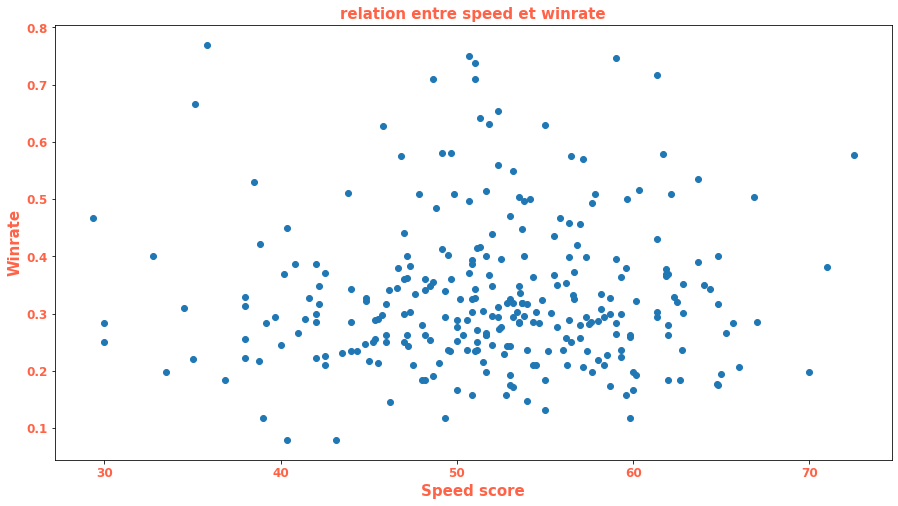

In [22]:
plt.figure(figsize=(15, 8))
plt.scatter( df_cor['buildUpPlaySpeed'],df_cor['winrate'])
plt.ylabel('Winrate',color='tomato', fontweight ='bold', fontsize = 15)
plt.xlabel('Speed score',color='tomato', fontweight ='bold', fontsize = 15)
plt.title('relation entre speed et winrate', color='tomato', fontweight ='bold', fontsize = 15);
plt.xticks(color='tomato', fontweight ='bold', fontsize = 12);
plt.yticks(color='tomato', fontweight ='bold', fontsize = 12)
plt.show()

In [23]:
np.corrcoef( df_cor['buildUpPlaySpeed'],df_cor['winrate'])

array([[1.       , 0.0229222],
       [0.0229222, 1.       ]])

On constate que l'augmentation de la vitesse de jeu a une correlation trés faible et le calcule du coéficient de corrélation le montre aussi avec un une valeur de 0.02

2. nous allons passer à la deuxième relation le **dribbling** et **winrate** mais nous allons premièrement résoudre le problème des valeurs nulles

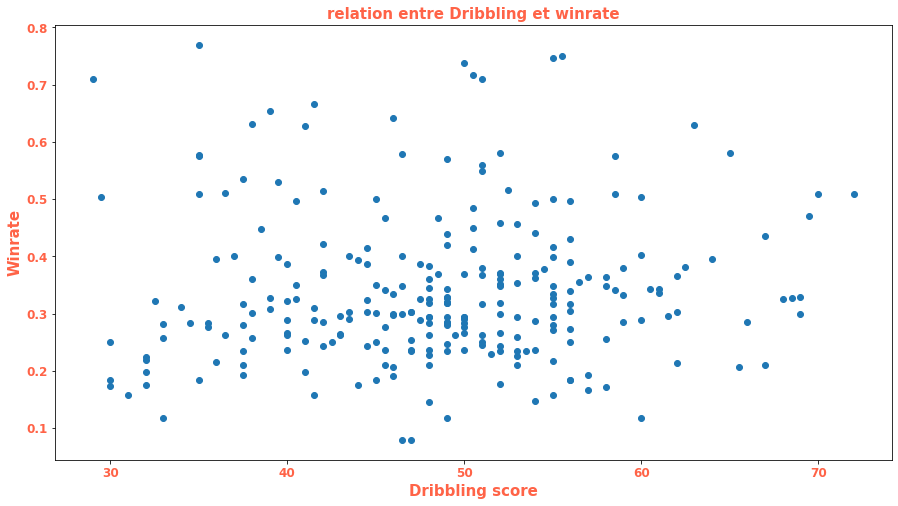

In [24]:
plt.figure(figsize=(15, 8))
plt.scatter( df_cor['buildUpPlayDribbling'],df_cor['winrate'])
plt.ylabel('Winrate',color='tomato', fontweight ='bold', fontsize = 15)
plt.xlabel('Dribbling score',color='tomato', fontweight ='bold', fontsize = 15)
plt.title('relation entre Dribbling et winrate', color='tomato', fontweight ='bold', fontsize = 15);
plt.xticks(color='tomato', fontweight ='bold', fontsize = 12);
plt.yticks(color='tomato', fontweight ='bold', fontsize = 12)
plt.show()

In [25]:
df_cor2 = df_cor.copy()
df_cor2.dropna(inplace=True)
df_cor2
np.corrcoef( df_cor2['buildUpPlayDribbling'],df_cor2['winrate'])

array([[1.        , 0.06093864],
       [0.06093864, 1.        ]])

la relation entre le dribble et le winrate est faiblement positive cela est montrer aussi avec le coéficient de corrélation qui est de 0.06

3. nous allons analyser la relation est les passes et le winrate

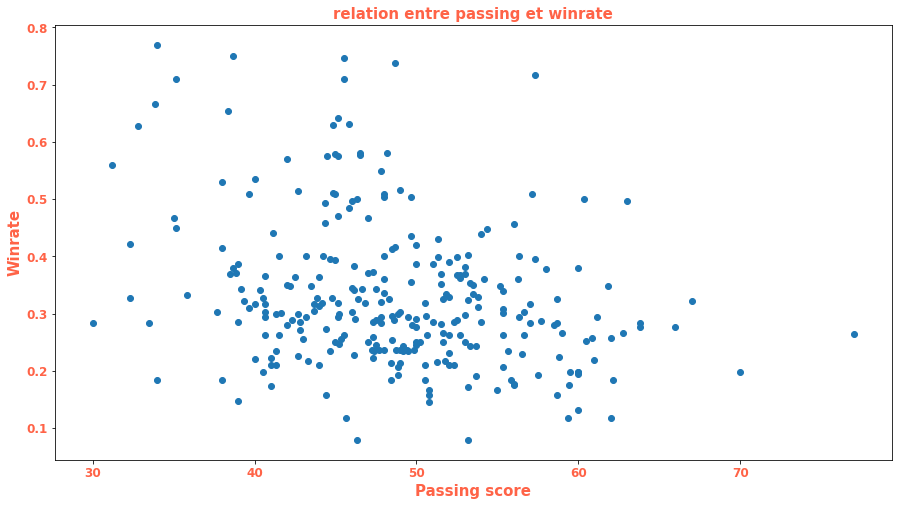

In [26]:
plt.figure(figsize=(15, 8))
plt.scatter( df_cor['buildUpPlayPassing'],df_cor['winrate'])
plt.ylabel('Winrate',color='tomato', fontweight ='bold', fontsize = 15)
plt.xlabel('Passing score',color='tomato', fontweight ='bold', fontsize = 15)
plt.title('relation entre passing et winrate', color='tomato', fontweight ='bold', fontsize = 15);
plt.xticks(color='tomato', fontweight ='bold', fontsize = 12);
plt.yticks(color='tomato', fontweight ='bold', fontsize = 12)
plt.show()

In [27]:
np.corrcoef( df_cor['buildUpPlayPassing'],df_cor['winrate'])

array([[ 1.      , -0.294345],
       [-0.294345,  1.      ]])

Contrairement aux attentes nous remarquons qu'il y a une relation négative un peu faible entre le score des passes et le winrate, cela devrait être encore plus analysé en profondeur pour avoir plus d'information avant d'avoir une conclusion

4. Finalement nous allons analyser la relation entre la création de chance de tir et le winrate

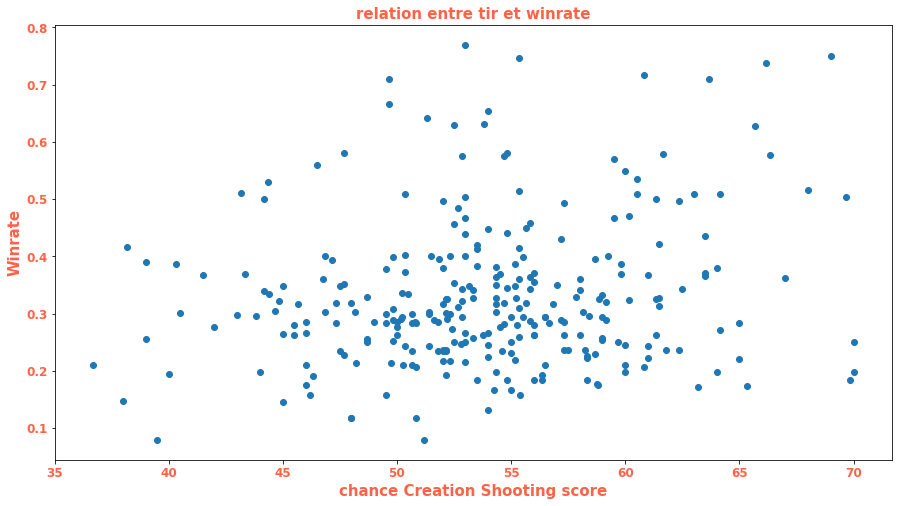

In [28]:
plt.figure(figsize=(15, 8))
plt.scatter( df_cor['chanceCreationShooting'],df_cor['winrate'])
plt.ylabel('Winrate',color='tomato', fontweight ='bold', fontsize = 15)
plt.xlabel('chance Creation Shooting score',color='tomato', fontweight ='bold', fontsize = 15)
plt.title('relation entre tir et winrate', color='tomato', fontweight ='bold', fontsize = 15);
plt.xticks(color='tomato', fontweight ='bold', fontsize = 12);
plt.yticks(color='tomato', fontweight ='bold', fontsize = 12)
plt.show()

In [29]:
np.corrcoef( df_cor['chanceCreationShooting'],df_cor['winrate'])

array([[1.        , 0.17548371],
       [0.17548371, 1.        ]])

la correlation entre le tir et positive mais faible et cela peux être analysé plus en profondeur car peut être il y a des équipes qui sont faible à rentabiliser les chances de tirs

<a id='conclusions'></a>
## Conclusions

Dans ce rapport nous avons essayé de analyser les points forts de chaque League avec un moyenne général sur une période entre 2008 et 2016 et cela nous a donner une idée sur le style de jeu de chaque League, après nous avons essayé de voir s'il y a une relation avec les attribut d'attaques de de chaque équipe et le Winrate de cette dernière et nous avons trouvé que les relation sont faible à individuellement ce qui nous pousse à la réflexion sur la combinaison d'attributs d'attaques et de défenses qui peux être explorer avec des modèles économétrique et de calculer l'impact générale du modèle sur la variable dépendant qui est le Winrate.<br>
L’ensemble des données analysée contient des limitations surtout la dataFrame des attributs. L'évaluations des équipes ne suit pas un enchainement chronologique pour toutes les équipes, on peut trouver des équipes qui ont 4 à 5 évaluations mais d'autre avec 3 évaluations, cette limitation nous a empêché d'analyser l'évolution de chaque équipe en winrate par rapport à l'évolution des leurs attributs ce qui pouvait nous montrer quel attribut avait jouer un rôle important sur l'évolution des résultats d'une équipes. 